1.) LFP-2.mat

In [1]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import spectrogram
from scipy import signal
import random as rand

In [2]:
# Load the data.
lfp2 = loadmat('LFP-2.mat')          # Load the data,
t = lfp2['t'][0]                     # ... extract t, the time variable,
LFP = lfp2['LFP'][0]                 # ... and LFP, the voltage variable.
dt = t[1] - t[0]                     # Define the sampling interval,
fNQ = 1 / dt / 2                     # ... and Nyquist frequency. 

i. Visualize the time series data. What rhythms do you observe? Do you detect evidence for CFC in your visualizations?

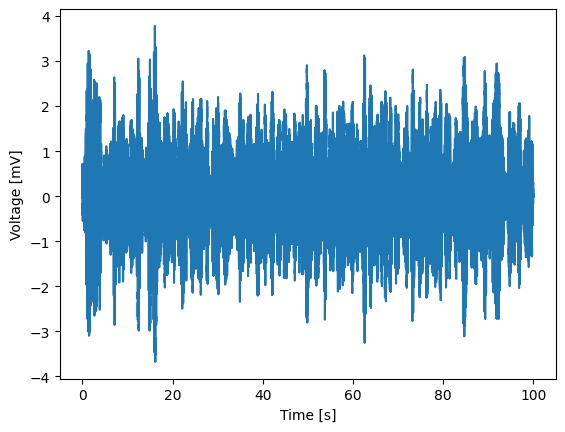

In [3]:
plt.plot(t,LFP)
plt.xlabel('Time [s]')       # ... with axes labeled.
plt.ylabel('Voltage [mV]');

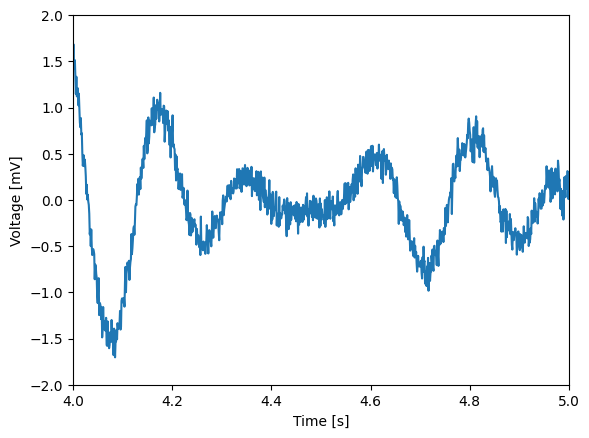

In [4]:
#zoom in on 1 second of activity 
plt.plot(t,LFP)
plt.xlim([4,5])
plt.ylim([-2, 2])
plt.xlabel('Time [s]')       # ... with axes labeled.
plt.ylabel('Voltage [mV]');
plt.show()

a dominant low-frequency rhythm - not really seeing any evidence of CFC so far

ii.) Plot the spectrum vs the frequency for this data

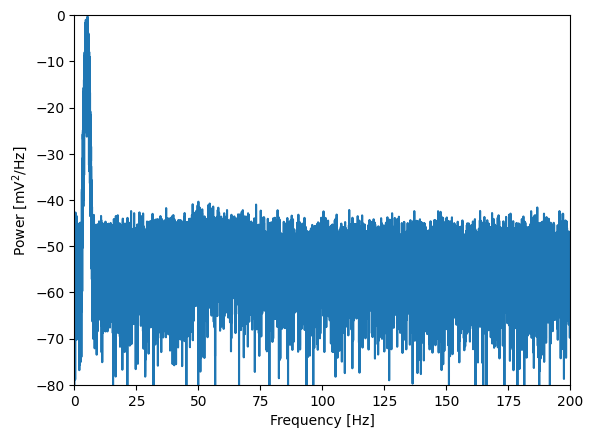

In [5]:
dt = t[1] - t[0]                # Define the sampling interval,
T = t[-1]                       # ... the duration of the data,
N = len(LFP)                    # ... and the no. of data points

x = np.hanning(N) * LFP            # Multiply data by a Hanning taper
xf = np.fft.rfft(x - x.mean())         # Compute Fourier transform
Sxx = 2*dt**2/T * (xf*np.conj(xf)) # Compute the spectrum
Sxx = np.real(Sxx)                 # Ignore complex components

df = 1 / T                      # Define frequency resolution,
fNQ = 1 / dt / 2                # ... and Nyquist frequency. 

faxis = np.arange(0, fNQ + df, df) # Construct freq. axis
plt.plot(faxis, 10 * np.log10(Sxx))    # Plot spectrum vs freq.
plt.xlim([0, 200])                  # Set freq. range, 
plt.ylim([-80, 0])                  # ... andplt. decibel range
plt.xlabel('Frequency [Hz]')        # Label the axes
plt.ylabel('Power [mV$^2$/Hz]');

This highlights a low-frequency peak around 5ish Hz that is also the largest - this corresponds to the dominanting slow rhythmn we saw last. 

iii.) APPLY the CFC method. What choices will you make, and why? What if any CFC do you find? 

In [6]:
# Low frequency band. (the dominant)
Wn = [5,7];                       # Set the passband for low frequency band 
n = 100;                            # ... and filter order,
                                    # ... build the bandpass filter,
b = signal.firwin(n, Wn, nyq=fNQ, pass_zero=False, window='hamming');
Vlo = signal.filtfilt(b, 1, LFP);   # ... and apply it to the data.

# High frequency band.
Wn = [75, 120];                      # Set the passband for high frequency band (but idontseeone....)
n = 100;                            # ... and filter order,
                                    # ... build the bandpass filter,
b = signal.firwin(n, Wn, nyq=fNQ, pass_zero=False, window='hamming');
Vhi = signal.filtfilt(b, 1, LFP);   # ... and apply it to the data.

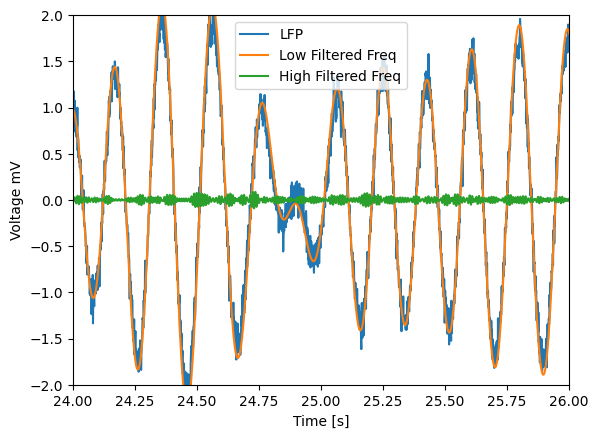

In [7]:
plt.plot(t, LFP)
plt.plot(t, Vlo) #plot the low peak 
plt.plot(t, Vhi) #plot the high freq peak
plt.xlabel('Time [s]')
plt.ylabel('Voltage mV')
plt.xlim([24, 26]); #zoom in a specific time interval to get a more detailed graph, lets say 2 seconds from 24 to 26 seconds
plt.ylim([-2,2]);
plt.legend(['LFP', 'Low Filtered Freq', "High Filtered Freq"])
plt.show()

In [8]:
phi = np.angle(signal.hilbert(Vlo))  # Compute phase of low-freq signal
amp = abs(signal.hilbert(Vhi))       # Compute amplitude of high-freq signal

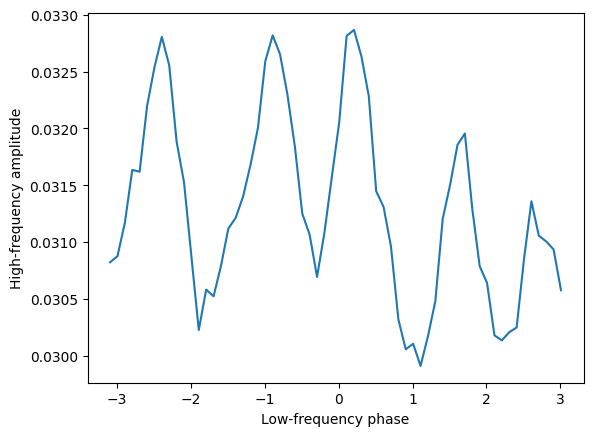

In [9]:
p_bins = np.arange(-np.pi, np.pi, 0.1)
a_mean = np.zeros(np.size(p_bins)-1)
p_mean = np.zeros(np.size(p_bins)-1)
for k in range(np.size(p_bins)-1):     #For each phase bin,
    pL = p_bins[k]                  #... lower phase limit,
    pR = p_bins[k+1]                #... upper phase limit.
    indices=(phi>=pL) & (phi<pR)    #Find phases falling in bin,
    a_mean[k] = np.mean(amp[indices])  #... compute mean amplitude,
    p_mean[k] = np.mean([pL, pR])      #... save center phase.

plt.plot(p_mean, a_mean)                #Plot the phase versus amplitude,
plt.ylabel('High-frequency amplitude')  #... with axes labeled.
plt.xlabel('Low-frequency phase');

This doesn't seem to suggest a CFC

In [10]:
h = max(a_mean)-min(a_mean)
print(h)

0.0029541809184905933


In [11]:
n_surrogates = 1000;                    #Define no. of surrogates.
hS = np.zeros(n_surrogates)                #Vector to hold h results.
for ns in range(n_surrogates):          #For each surrogate,
    ampS = amp[np.random.randint(0,N,N)]          #Resample amplitude,
    p_bins = np.arange(-np.pi, np.pi, 0.1)       #Define the phase bins
    a_mean = np.zeros(np.size(p_bins)-1)      #Vector for average amps.
    p_mean = np.zeros(np.size(p_bins)-1)      #Vector for phase bins.
    for k in range(np.size(p_bins)-1):
        pL = p_bins[k]                  #... lower phase limit,
        pR = p_bins[k+1]                #... upper phase limit.
        indices=(phi>=pL) & (phi<pR)    #Find phases falling in bin,
        a_mean[k] = np.mean(ampS[indices]) #... compute mean amplitude,
        p_mean[k] = np.mean([pL, pR])      #... save center phase.
    hS[ns] = max(a_mean)-min(a_mean)    # Store surrogate h.

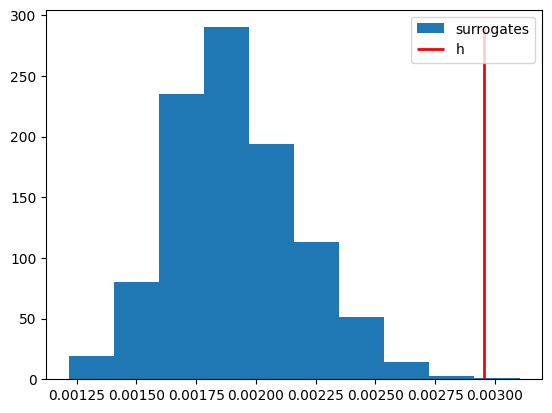

In [12]:
counts, _, _ = plt.hist(hS, label='surrogates')               # Plot the histogram of hS, and save the bin counts.
plt.vlines(h, 0, max(counts), colors='red', label='h', lw=2)  # Plot the observed h,
plt.legend();                                                 # ... include a legend.

In [13]:
p = sum([s > h for s in hS]) / len(hS) #what is the proportion of surrogante h values greater than the observed h values
print(p)

0.001


put this results suggests a significant h.... which would reject the null hypothesis of there being no CFC between the phases....

"As a statistician would say, we reject the null hypothesis of no CFC between the phase of the 5-7 Hz low-frequency band and the amplitude of the 80-120 Hz high frequency band."